In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from collections import namedtuple

import seaborn as sns

In [3]:
### General Processing

In [4]:
main = pd.read_excel('Movant Report Analysis (01.01.2016-08.31.2019) - unlinked.xlsx', sheet_name = 'KM Data Edits')
datapull = pd.read_excel('Movant Report Analysis (01.01.2016-08.31.2019) - unlinked.xlsx', sheet_name = 'Data Pull Sheet')
aums = pd.read_excel('Movant Report Analysis (01.01.2016-08.31.2019) - unlinked.xlsx', sheet_name = 'All Institution AUMs')
removed = pd.read_excel('Movant Report Analysis (01.01.2016-08.31.2019) - unlinked.xlsx', sheet_name = 'Removed cases')

In [7]:
#remove N/A data in Excel

main = main[:-6]

In [11]:
removed_tickers = pd.read_csv("excluded.csv").Ticker

In [12]:
movant_categories = main["Movant ID"].str.split(".", n=2, expand = True)
main['Movant Group'] = movant_categories[0]+movant_categories[1]

In [13]:
main = main.merge(aums[['Institutional Movant', 'AUM']], how = 'left', left_on = 'Movant', right_on = 'Institutional Movant')

In [14]:
main = main.merge(datapull[['Ticker','Damage Bucket', "Filing Firm", "Lead Plaintiff"]], how = 'left', on = 'Ticker')

In [15]:
main["Type (Ind, Ins, G-Ind, G-Ins, G-Mix)"] = main["Type (Ind, Ins, G-Ind, G-Ins, G-Mix)"].str.replace("InS", "Ins")
main["Type (Ind, Ins, G-Ind, G-Ins, G-Mix)"] = main["Type (Ind, Ins, G-Ind, G-Ins, G-Mix)"].str.replace("ins", "Ins")
main["Type (Ind, Ins, G-Ind, G-Ins, G-Mix)"] = main["Type (Ind, Ins, G-Ind, G-Ins, G-Mix)"].str.replace("G-mix", "G-Mix")
main["Type (Ind, Ins, G-Ind, G-Ins, G-Mix)"] = main["Type (Ind, Ins, G-Ind, G-Ins, G-Mix)"].str.replace("ind", "Ind")
main["Type (Ind, Ins, G-Ind, G-Ins, G-Mix)"] = main["Type (Ind, Ins, G-Ind, G-Ins, G-Mix)"].str.replace("g-Ind", "G-Ind")

In [16]:
main["Small Case"] = 0
main.loc[main["Damage Bucket"].isin(["A","B"]), "Small Case"] = 1 
main.loc[main["Lead Plaintiff"].isna(),"Lead Plaintiff"] = "None"

In [17]:
def win(a, b):
    if a in b: return 1
    else: return 0

main = main.assign(win = main.apply(lambda row: win(row["Movant"], row["Lead Plaintiff"]), axis =1))

In [18]:
main["unopposed"] = 0
main.loc[main["Contested/\nUncontested"]=="Uncontested", "unopposed"] = 1

In [19]:
#main["AUM"] = main.apply(lambda x: '${:,.2f}'.format(x["AUM"]), axis = 1)
#main["Movant Loss"] = main.apply(lambda x: '${:,.2f}'.format(x["Movant Loss"]), axis = 1)
#datapull["Total Damages"] = datapull.apply(lambda x: '${:,.2f}'.format(x["Total Damages"]), axis = 1)

### I. MOVANT ANALYSIS BY REPORTED DAMAGES BY BUCKET

#### I. A. Number of Cases by Bucket

In [20]:
data_1 = datapull[datapull["Damage Bucket"] != "DC"]

In [21]:
data_1a = data_1['Damage Bucket'].value_counts()

In [22]:
y_val = data_1a.sort_index()
x_val = data_1a.sort_index().index

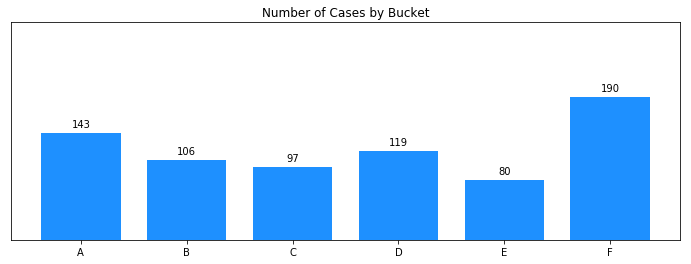

In [23]:
fig, ax = plt.subplots(figsize=(12,4))
width = 0.75
ind = np.arange(len((y_val)))
plt.title('Number of Cases by Bucket')
plt.yticks([], [])
ax.bar(x_val, y_val, width, color = "dodgerblue")

ax.set_ylim([0,y_val.max()+ 100])

rects = ax.patches

ax.yaxis.set_ticks_position('none')

for rect, label in zip(rects, y_val):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width() / 2, height + 5, label,
            ha='center', va='bottom')
plt.show()

#### I.B. Analysis by Bucket

In [24]:
data_1b = data_1[['Damage Bucket', 'Ticker','Total Damages', '% of Total Damages']].dropna()
data_1b['Total Damages'] = pd.to_numeric(data_1b['Total Damages'], errors='coerce').fillna(0)
data_1b['% of Total Damages'] = pd.to_numeric(data_1b['% of Total Damages'], errors='coerce').fillna(0)
data_1b = data_1b[~data_1b.Ticker.isin(data_1b[(data_1b['Damage Bucket']=='DC')]['Ticker'])]


In [25]:
data_1b_total = data_1b[['Damage Bucket', 'Ticker','Total Damages']]
data_1b_describe_total = data_1b_total.pivot_table(index = 'Ticker', columns = 'Damage Bucket', values = 'Total Damages')
data_1b_describe_total = data_1b_describe_total.describe()

In [26]:
data_1b_bps = data_1b[['Damage Bucket', 'Ticker','% of Total Damages']]
data_1b_describe_bps = data_1b_bps.pivot_table(index = 'Ticker', columns = 'Damage Bucket', values = '% of Total Damages')
data_1b_describe_bps = data_1b_describe_bps.describe()

In [27]:
x_val = np.sort(data_1b['Damage Bucket'].unique())

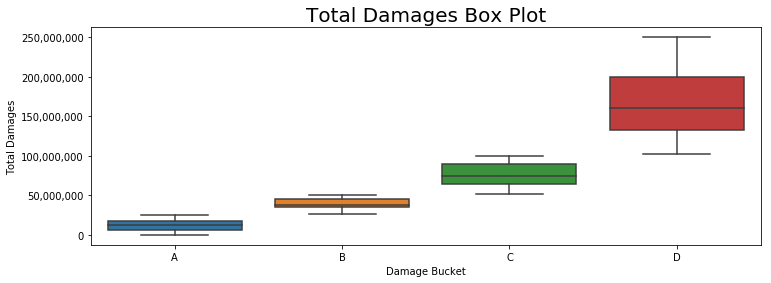

In [28]:
#### plt.clf()
pd.options.display.float_format = '${:,.0f}'.format
plt.figure(figsize=(12,4))
plt.title("Total Damages Box Plot", size = 20)
ax = sns.boxplot(y = 'Total Damages', x = 'Damage Bucket', data = data_1b_total[~data_1b_total["Damage Bucket"].isin(["E", "F"])], order = x_val[:4], showfliers=False)
ax.get_yaxis().set_major_formatter(FuncFormatter(lambda y, p: format(int(y), ',')))
plt.show()

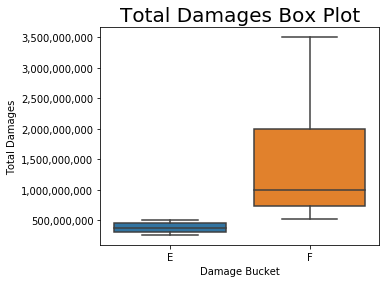

In [29]:
plt.figure(figsize=(5,4))
plt.title("Total Damages Box Plot", size = 20)
ax = sns.boxplot(y = 'Total Damages', x = 'Damage Bucket', data = data_1b_total[data_1b_total["Damage Bucket"].isin(["DC", "E", "F"])], order = x_val[4:7], showfliers=False)
ax.get_yaxis().set_major_formatter(FuncFormatter(lambda y, p: format(int(y), ',')))
plt.show()

In [30]:
print("By Total Damage")
data_1b_describe_total

By Total Damage


Damage Bucket,A,B,C,D,E,F
count,$143,$106,$97,$119,$80,$190
mean,"$12,352,797","$38,329,245","$76,113,402","$168,672,269","$381,987,500","$2,482,684,211"
std,"$7,291,582","$6,644,955","$14,861,777","$41,460,030","$79,429,850","$4,092,459,210"
min,$0,"$26,000,000","$52,000,000","$102,000,000","$260,000,000","$515,000,000"
25%,"$6,000,000","$35,000,000","$65,000,000","$133,000,000","$300,000,000","$741,250,000"
50%,"$12,000,000","$37,500,000","$75,000,000","$160,000,000","$370,000,000","$1,000,000,000"
75%,"$17,500,000","$45,000,000","$90,000,000","$200,000,000","$450,000,000","$2,000,000,000"
max,"$25,000,000","$50,000,000","$100,000,000","$250,000,000","$500,000,000","$25,000,000,000"


In [31]:
pd.options.display.float_format = '{:,.2%}'.format
print("By BPS, Does Not Include DC Damages in Bucket F")
data_1b_describe_bps 

By BPS, Does Not Include DC Damages in Bucket F


Damage Bucket,A,B,C,D,E,F
count,"14,300.00%","10,600.00%","9,700.00%","11,900.00%","8,000.00%","19,000.00%"
mean,2.67%,1.10%,0.49%,0.61%,0.36%,"1,148,961.69%"
std,5.85%,2.00%,1.02%,1.64%,0.76%,"15,837,338.69%"
min,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%
25%,0.08%,0.06%,0.02%,0.04%,0.01%,0.01%
50%,0.51%,0.33%,0.12%,0.16%,0.08%,0.09%
75%,2.01%,1.24%,0.46%,0.40%,0.31%,0.31%
max,38.40%,13.61%,6.80%,12.57%,4.90%,"218,302,649.00%"


#### Largest and 2nd Largest Bucket

In [32]:
for i in x_val:
    data_1b_largest = np.sort(main[(main["Damage Bucket"] == i) & (~main["Ticker"].isin(removed_tickers))].pivot_table(index = "Movant ID", columns = "Ticker", values = "Total Damages in Group").fillna(0), axis = 0)[-2:,:]
    if i == "A":
        data_1b_largest1 = pd.DataFrame(np.transpose(np.transpose(data_1b_largest)[np.all(data_1b_largest != 0, axis =0)])[1]).describe()
        data_1b_largest2 = pd.DataFrame(np.transpose(np.transpose(data_1b_largest)[np.all(data_1b_largest != 0, axis =0)])[0]).describe()
    else:
        data_1b_largest1 = pd.concat([data_1b_largest1, pd.DataFrame(np.transpose(np.transpose(data_1b_largest)[np.all(data_1b_largest != 0, axis =0)])[1]).describe()], axis = 1)       
        data_1b_largest2 = pd.concat([data_1b_largest2, pd.DataFrame(np.transpose(np.transpose(data_1b_largest)[np.all(data_1b_largest != 0, axis =0)])[0]).describe()], axis = 1)

In [33]:
data_1b_largest1.columns = x_val.tolist()
data_1b_largest2.columns = x_val.tolist()

In [34]:
pd.options.display.float_format = '${:,.0f}'.format
print("Largest Movants")
data_1b_largest1

Largest Movants


,A,B,C,D,E,F
count,$86,$64,$56,$82,$49,$148
mean,"$199,619","$403,295","$283,828","$850,191","$990,913","$5,309,050"
std,"$320,485","$440,169","$279,111","$1,213,216","$1,142,903","$9,883,262"
min,"$1,667","$6,854","$12,153","$4,364","$37,834","$4,060"
25%,"$34,917","$85,958","$88,018","$172,656","$188,361","$691,304"
50%,"$82,494","$189,998","$183,862","$473,656","$507,588","$2,003,333"
75%,"$225,422","$654,527","$385,824","$862,865","$1,315,108","$5,060,817"
max,"$2,139,620","$1,733,507","$1,179,088","$6,373,736","$5,439,420","$68,161,973"


In [35]:
pd.options.display.float_format = '${:,.0f}'.format
print("Second Largest Movants")
data_1b_largest2

Second Largest Movants


,A,B,C,D,E,F
count,$86,$64,$56,$82,$49,$148
mean,"$62,422","$123,979","$96,023","$259,366","$345,828","$1,717,761"
std,"$94,745","$158,953","$115,515","$467,309","$410,046","$3,882,284"
min,$998,"$4,025","$6,424","$1,172","$1,643",$33
25%,"$5,518","$23,408","$24,592","$67,280","$60,034","$160,128"
50%,"$23,654","$57,997","$57,188","$190,390","$198,000","$702,423"
75%,"$73,802","$133,149","$121,105","$308,605","$454,775","$1,642,096"
max,"$465,143","$715,015","$533,682","$4,124,236","$1,762,886","$30,462,907"


#### I.C. Win-Loss Analysis

In [36]:
data_1c = main[main["Damage Bucket"] != "DC"][["Movant", "Damage Bucket", "Type", "win", "Type (Ind, Ins, G-Ind, G-Ins, G-Mix)"]]

#### I.C.1 Largest Movant

In [37]:
data_1c1_wins = main.groupby("Movant")["win"].agg(["sum", "count"])
data_1c1_wins["win_rate"] = data_1c1_wins["sum"]/data_1c1_wins["count"]
data_1c1_losses_inst = main[main.Type == "Institution"].groupby("Movant")["Movant Loss"].sum()
data_1c1_losses_ind = main[main.Type == "Individual"].groupby("Movant")["Movant Loss"].sum()
data_1c1_largest_inst = data_1c1_losses_inst[data_1c1_losses_inst == data_1c1_losses_inst.max()].index
data_1c1_largest_ind = data_1c1_losses_ind[data_1c1_losses_ind == data_1c1_losses_ind.max()].index

In [38]:
pd.options.display.float_format = '{:,.2f}'.format
print("The number of wins, cases and win rate of the largest institutional movant is")
data_1c1_wins[data_1c1_wins.index.isin(data_1c1_largest_inst)]

The number of wins, cases and win rate of the largest institutional movant is


,sum,count,win_rate
Movant,,,
Union Asset Management Holding AG,7,8,0.88


In [39]:
pd.options.display.float_format = '{:,.2f}'.format
print("The number of wins, cases and win rate of the largest individual movant is")
data_1c1_wins[data_1c1_wins.index.isin(data_1c1_largest_ind)]

The number of wins, cases and win rate of the largest individual movant is


,sum,count,win_rate
Movant,,,
Dan Kleinerman,1,3,0.33


In [40]:
#### I.C.2 Win Rate by Movant Category

In [41]:
data_1c2 = data_1c.groupby("Type")["win"].agg(["sum", "count"])
data_1c2["win_rate"] = data_1c2["sum"]/data_1c2["count"]

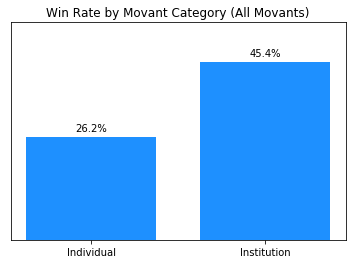

In [42]:
x_val = data_1c2.index
y_val = data_1c2.win_rate

fig, ax = plt.subplots(figsize=(6,4))
width = 0.75
ind = np.arange(len((y_val)))
plt.title('Win Rate by Movant Category (All Movants)')
plt.yticks([], [])
ax.bar(x_val, y_val, width, color = "dodgerblue")

rects = ax.patches

ax.yaxis.set_ticks_position('none')

ax.set_ylim([0,y_val.max()+ 0.1])

for rect, label in zip(rects, y_val):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width() / 2, height + 0.01, "{:,.1%}".format(label),
            ha='center', va='bottom')
plt.show()

In [43]:
#### I.C.3. Win Rate By Bucket

In [44]:
data_1c3 = data_1c.groupby("Damage Bucket")["win"].agg(["sum", "count"])
data_1c3["win_rate"] = data_1c3["sum"]/data_1c3["count"]

In [45]:
x_val = data_1c3.index
y_val = data_1c3.win_rate

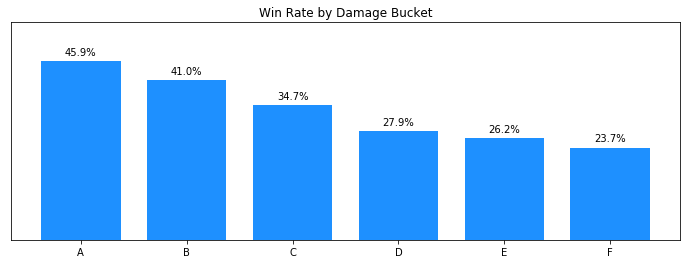

In [46]:

fig, ax = plt.subplots(figsize=(12,4))
width = 0.75
ind = np.arange(len((y_val)))
plt.title('Win Rate by Damage Bucket')
plt.yticks([], [])
ax.bar(x_val, y_val, width, color = "dodgerblue")

rects = ax.patches

ax.yaxis.set_ticks_position('none')

ax.set_ylim([0,y_val.max()+ 0.1])

for rect, label in zip(rects, y_val):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width() / 2, height + 0.01, "{:,.1%}".format(label),
            ha='center', va='bottom')
plt.show()

In [47]:
#### I.C.4. Win Rate By Bucket by Movant Type

In [48]:
data_1c4 = data_1c.groupby(["Type (Ind, Ins, G-Ind, G-Ins, G-Mix)", "Damage Bucket"])["win"].agg(["sum", "count"])
data_1c4["win_rate"] = data_1c4["sum"]/data_1c4["count"]

In [49]:
x_val = data_1c4.index
y_val = data_1c4.win_rate

In [50]:
x_val

MultiIndex(levels=[['G-Ind', 'G-Ins', 'G-Mix', 'Ind', 'Ins'], ['A', 'B', 'C', 'D', 'E', 'F']],
           labels=[[0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4], [0, 1, 2, 3, 4, 5, 0, 1, 2, 3, 4, 5, 0, 1, 2, 3, 4, 5, 0, 1, 2, 3, 4, 5, 0, 1, 2, 3, 4, 5]],
           names=['Type (Ind, Ins, G-Ind, G-Ins, G-Mix)', 'Damage Bucket'])

In [51]:
y_val["G-Ind"]

Damage Bucket
A   0.46
B   0.42
C   0.23
D   0.23
E   0.04
F   0.11
Name: win_rate, dtype: float64

In [52]:
y_val

Type (Ind, Ins, G-Ind, G-Ins, G-Mix)  Damage Bucket
G-Ind                                 A               0.46
                                      B               0.42
                                      C               0.23
                                      D               0.23
                                      E               0.04
                                      F               0.11
G-Ins                                 A               1.00
                                      B               0.67
                                      C               0.78
                                      D               0.51
                                      E               0.57
                                      F               0.44
G-Mix                                 A               0.67
                                      B               0.68
                                      C               0.60
                                      D               0.28
    

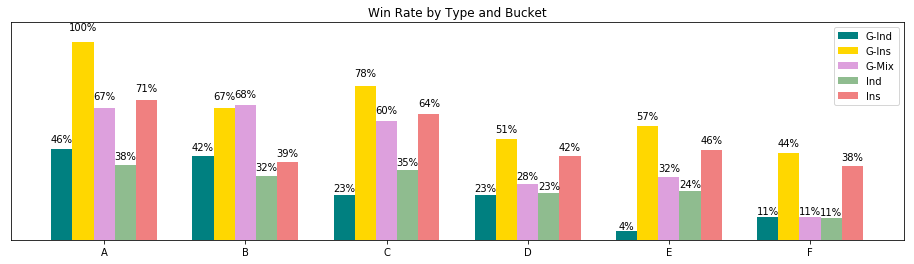

In [53]:
fig, ax = plt.subplots(figsize=(16,4))
width = 0.15
ind = np.arange(6)
legends = ["G-Ind", "G-Ins", "G-Mix", "Ind", "Ins"]
buckets = ["A", "B", "C", "D", "E", "F"]
colors=['teal', 'gold', 'plum', 'darkseagreen', 'lightcoral', "mediumorchid"]

plt.title('Win Rate by Type and Bucket')
plt.yticks([], [])

rects = []

for i in range(len(legends)):
    box = ax.bar(ind + width*(i-1), y_val[legends[i]], width, color = colors[i], label = legends[i])
    rects.append(box)

plt.legend([i for i in rects], legends)


ax.set_xticks(ind+width)
ax.set_xticklabels(buckets)
ax.yaxis.set_ticks_position('none')
ax.set_ylim([0,y_val.max()+ 0.1])

def autolabel(i):
    for rect in i:
        h = rect.get_height()
        ax.text(rect.get_x()+rect.get_width()/2., 1.05*h, "{:,.0%}".format(h),
                ha='center', va='bottom')
        
for i in rects:
    autolabel(i)



plt.show()

### II. ANALYSIS BY TYPE OF MOVANT

#### II. A. Number of Movants by Bucket

In [54]:
data_2 = main[main["Damage Bucket"] != "DC"]

In [55]:
data_2a = data_2["Damage Bucket"].value_counts()

In [56]:
y_val = data_2a.sort_index()
x_val = data_2a.sort_index().index

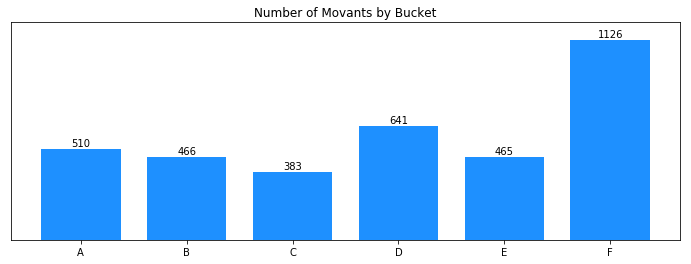

In [57]:
fig, ax = plt.subplots(figsize=(12,4))
width = 0.75
ind = np.arange(len((y_val)))
plt.title('Number of Movants by Bucket')
plt.yticks([], [])
ax.bar(x_val, y_val, width, color = "dodgerblue")

rects = ax.patches

ax.yaxis.set_ticks_position('none')

ax.set_ylim([0,y_val.max()+ 100])

for rect, label in zip(rects, y_val):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width() / 2, height + 5, label,
            ha='center', va='bottom')
plt.show()

#### II.B. Number of Movants by Case

In [58]:
data_2b = data_2.groupby("Ticker")["Movant ID"].count().reset_index()
data_2b_describe = data_2b.describe()

In [59]:
pd.options.display.float_format = '{:.2f}'.format
data_2b_describe

,Movant ID
count,691.00
mean,5.20
std,4.12
min,1.00
25%,2.00
50%,4.00
75%,7.00
max,26.00


#### II.C. Movant By Type By Bucket

In [60]:
data_2c = data_2[["Damage Bucket", "Type (Ind, Ins, G-Ind, G-Ins, G-Mix)", "Movant ID"]]

In [61]:
data_2c_grouped = data_2c.groupby(["Damage Bucket", "Type (Ind, Ins, G-Ind, G-Ins, G-Mix)"])["Movant ID"].count().reset_index()

In [62]:
data_2c_grouped

,Damage Bucket,"Type (Ind, Ins, G-Ind, G-Ins, G-Mix)",Movant ID
0,A,G-Ind,277
1,A,G-Ins,8
2,A,G-Mix,21
3,A,Ind,180
4,A,Ins,24
5,B,G-Ind,265
6,B,G-Ins,9
7,B,G-Mix,25
8,B,Ind,139
9,B,Ins,28


#### II.D. For Groups

In [63]:
data_2d_type = data_2[["Movant Group", "Type (Ind, Ins, G-Ind, G-Ins, G-Mix)", "Movant Loss", "Movant ID", "win"]]
data_2d_type_groupcount = data_2d_type.groupby("Type (Ind, Ins, G-Ind, G-Ins, G-Mix)")["Movant ID"].nunique()/data_2d_type.groupby("Type (Ind, Ins, G-Ind, G-Ins, G-Mix)")["Movant Group"].nunique()
data_2d_type_groupcount = data_2d_type_groupcount.append(pd.Series(data_2d_type["Movant ID"].nunique()/data_2d_type["Movant Group"].nunique(), index = ["Total"]))
data_2d_type_loss = data_2d_type.groupby("Type (Ind, Ins, G-Ind, G-Ins, G-Mix)")["Movant Loss"].mean()
data_2d_type_loss = data_2d_type_loss.append(pd.Series(main["Movant Loss"].mean(), index = ["Total"]))
data_2d_type_winrate = data_2d_type.groupby("Type (Ind, Ins, G-Ind, G-Ins, G-Mix)")["win"].sum()/data_2d_type.groupby("Type (Ind, Ins, G-Ind, G-Ins, G-Mix)")["win"].count()
data_2d_type_winrate = data_2d_type_winrate.append(pd.Series(main["win"].sum()/main["win"].count(), index = ["Total"]))

data_2d_type = pd.concat([data_2d_type_groupcount, data_2d_type_loss, data_2d_type_winrate], axis = 1)
data_2d_type.columns = ["Avg # of Members for Each Type", "Avg Losses", "Win Rate"]
data_2d_type["Avg Losses"] = data_2d_type.apply(lambda x: '${:,.2f}'.format(x["Avg Losses"]), axis = 1)
data_2d_type["Win Rate"] = data_2d_type.apply(lambda x: "{:,.1%}".format(x["Win Rate"]), axis = 1)

print("Statistics by Type")
pd.options.display.float_format = '{:,.2f}'.format
data_2d_type

Statistics by Type


,Avg # of Members for Each Type,Avg Losses,Win Rate
G-Ind,2.87,"$147,619.69",26.3%
G-Ins,2.51,"$1,763,328.13",50.6%
G-Mix,2.93,"$858,197.71",34.6%
Ind,1.04,"$305,961.08",25.6%
Ins,1.03,"$2,364,479.52",42.6%
Total,1.62,"$700,084.55",31.7%


In [64]:
data_2d_type_bucket = data_2[["Damage Bucket", "Movant Group", "Type (Ind, Ins, G-Ind, G-Ins, G-Mix)", "Movant Loss", "Movant ID", "win"]]
data_2d_type_bucket_groupcount = data_2d_type_bucket.groupby(["Damage Bucket", "Type (Ind, Ins, G-Ind, G-Ins, G-Mix)"])["Movant ID"].nunique()/data_2d_type_bucket.groupby("Type (Ind, Ins, G-Ind, G-Ins, G-Mix)")["Movant Group"].nunique()
data_2d_type_bucket_groupcount = data_2d_type_bucket_groupcount.append(pd.Series(data_2d_type_bucket["Movant ID"].nunique()/data_2d_type_bucket["Movant Group"].nunique(), index = ["Total"]))
data_2d_type_bucket_loss = data_2d_type_bucket.groupby(["Damage Bucket", "Type (Ind, Ins, G-Ind, G-Ins, G-Mix)"])["Movant Loss"].mean()
data_2d_type_bucket_loss = data_2d_type_bucket_loss.append(pd.Series(main["Movant Loss"].mean(), index = ["Total"]))
data_2d_type_bucket_winrate = data_2d_type_bucket.groupby(["Damage Bucket", "Type (Ind, Ins, G-Ind, G-Ins, G-Mix)"])["win"].sum()/data_2d_type_bucket.groupby("Type (Ind, Ins, G-Ind, G-Ins, G-Mix)")["win"].count()
data_2d_type_bucket_winrate = data_2d_type_bucket_winrate.append(pd.Series(main["win"].sum()/main["win"].count(), index = ["Total"]))

data_2d_type_bucket = pd.concat([data_2d_type_bucket_groupcount, data_2d_type_bucket_loss, data_2d_type_bucket_winrate], axis = 1)
data_2d_type_bucket.columns = ["Avg # of Members for Each Type", "Avg Losses", "Win Rate"]
data_2d_type_bucket["Avg Losses"] = data_2d_type_bucket.apply(lambda x: '${:,.2f}'.format(x["Avg Losses"]), axis = 1)
data_2d_type_bucket["Win Rate"] = data_2d_type_bucket.apply(lambda x: "{:,.1%}".format(x["Win Rate"]), axis = 1)

print("Statistics by type_bucket")
pd.options.display.float_format = '{:,.2f}'.format
data_2d_type_bucket

Statistics by type_bucket


,Avg # of Members for Each Type,Avg Losses,Win Rate
"(A, G-Ind)",0.55,"$88,073.03",8.8%
"(A, G-Ins)",0.06,"$1,319,486.54",2.3%
"(A, G-Mix)",0.29,"$114,506.81",6.5%
"(A, Ind)",0.18,"$129,962.31",6.5%
"(A, Ins)",0.04,"$252,731.04",3.2%
"(B, G-Ind)",0.53,"$123,293.89",7.7%
"(B, G-Ins)",0.07,"$749,425.47",1.7%
"(B, G-Mix)",0.34,"$324,959.67",7.9%
"(B, Ind)",0.14,"$140,472.07",4.3%
"(B, Ins)",0.05,"$268,218.23",2.1%


#### II.E. For Unopposed Lead Plaintiff Motions

In [65]:
data_2e = data_2[data_2["unopposed"]==1][["Damage Bucket","Movant","Movant Loss"]]

#### III.E.1. Number of Unopposed by Bucket

In [66]:
data_2e1 = data_2e.groupby("Damage Bucket")["Movant"].count().reset_index()

In [67]:
data_2e1

,Damage Bucket,Movant
0,A,63
1,B,36
2,C,39
3,D,24
4,E,19
5,F,21


#### II.E.2 Average Loss of Unopposed by Bucket

In [68]:
data_2e2 = data_2e.groupby("Damage Bucket")["Movant Loss"].mean().reset_index()
data_2e2["Movant Loss"] = data_2e2.apply(lambda x: '${:,.2f}'.format(x["Movant Loss"]), axis = 1)


In [69]:
pd.options.display.float_format = '${:,.2}'.format
data_2e2

,Damage Bucket,Movant Loss
0,A,"$42,385.57"
1,B,"$53,722.50"
2,C,"$76,122.45"
3,D,"$101,289.51"
4,E,"$220,700.18"
5,F,"$3,989,447.00"


#### II.F. Fight Analysis

In [70]:
data_2f = main[["Small Case", "Type", "win"]]

In [71]:
data2f_wins = data_2f.groupby(["Small Case", "Type"])["win"].agg(["sum", "count"])
data2f_wins["win_rate"] = data2f_wins["sum"]/  data2f_wins["count"]

In [72]:
pd.options.display.float_format = '{:.1%}'.format
data2f_wins["win_rate"].reset_index()

,Small Case,Type,win_rate
0,0,Individual,19.6%
1,0,Institution,43.5%
2,1,Individual,41.3%
3,1,Institution,65.6%


### III. ANALYSIS BY INSTITUTIONAL MOVEMENT TYPE

#### III. A. Institutional Movants by Bucket

In [73]:
data_3 = main[(main["Type"]== "Institution") & (main["Damage Bucket"] != "DC")]

In [74]:
data_3a = data_3.groupby('Damage Bucket')['Institutional Movant'].count()

In [75]:
y_val = data_3a.sort_index()
x_val = data_3a.sort_index().index

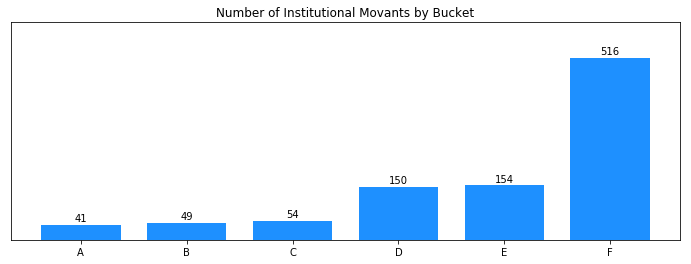

In [76]:
fig, ax = plt.subplots(figsize=(12,4))
width = 0.75
ind = np.arange(len((y_val)))
plt.title('Number of Institutional Movants by Bucket')
plt.yticks([], [])
ax.bar(x_val, y_val, width, color = "dodgerblue")

rects = ax.patches

ax.yaxis.set_ticks_position('none')

ax.set_ylim([0,y_val.max()+ 100])

for rect, label in zip(rects, y_val):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width() / 2, height + 5, label,
            ha='center', va='bottom')
plt.show()

#### III.B Average Loss By Institutional Movant by Bucket
#### Note: Does not include institutional movants without losses (N/A)

In [77]:
data_3b = data_3[['Damage Bucket',  "Type", 'Movant Loss']].dropna()
data_3b_describe = data_3b.pivot(columns = 'Damage Bucket', values = 'Movant Loss')
data_3b_describe = data_3b_describe.describe()

In [78]:
pd.options.display.float_format = '{:.0f}'.format
print("Duplicate institutional movants")
data_3b_describe

Duplicate institutional movants


Damage Bucket,A,B,C,D,E,F
count,41,49,54,149,148,505
mean,441804,397619,395644,714849,995718,3179632
std,1212305,595270,808751,1734757,2631200,7690971
min,875,5401,1050,112,1609,924
25%,51588,85118,46455,96188,111205,254025
50%,153220,145075,135858,246958,274612,723078
75%,380228,492329,391554,518591,731367,2202906
max,7793640,2813256,4725022,13674214,23517243,87214281


In [79]:
print("Unique institutional movants")
data_3b1 = data_3[['Damage Bucket', "Movant", "Type", 'Movant Loss']].dropna()
data_3b1 = data_3b1.groupby(["Movant","Type","Damage Bucket"])["Movant Loss"].sum().reset_index()
data_3b1 = data_3b1.pivot(columns = 'Damage Bucket', values = 'Movant Loss')
data_3b1_describe = data_3b1.describe()

Unique institutional movants


In [80]:
data_3b1_describe

Damage Bucket,A,B,C,D,E,F
count,38,47,51,121,117,305
mean,476683,414539,418917,880268,1259541,5264637
std,1259582,603688,830499,2306726,2978749,12754267
min,875,5401,1050,112,1609,924
25%,55929,86371,55659,99101,120608,301362
50%,162902,146994,128942,268919,342061,915166
75%,383104,529283,429502,737546,1103079,3590705
max,7793640,2813256,4725022,18784436,23517243,95946170


#### III.C. Average Loss By Winning Institutional Movant by Bucket
#### Note: Does not include institutional movants without losses (N/A)

In [81]:
data_3c = data_3[data_3.win==1][['Damage Bucket',  "Type", 'Movant Loss']].dropna()
data_3c_describe = data_3c.pivot(columns = 'Damage Bucket', values = 'Movant Loss')
data_3c_describe = data_3c_describe.describe()

In [82]:
data_3c_describe

Damage Bucket,A,B,C,D,E,F
count,32,27,35,64,75,198
mean,516957,483075,502777,1191733,1373930,4544071
std,1361965,749487,966995,2487095,3314680,10173080
min,11534,5401,1050,500,32033,15224
25%,78644,80829,93742,184464,165189,358998
50%,170972,152456,193034,336260,323001,1111900
75%,381650,630205,430921,940687,1089962,3884773
max,7793640,2813256,4725022,13674214,23517243,87214281


#### III.D. Average AUM of Institutional Movant by Bucket
##### Note: Count Includes Only Institutional Movants with AUMs (no N/As)

In [83]:
data_3d = main[['Damage Bucket',  "Institutional Movant", "AUM"]].dropna()
data_3d_describe = data_3d.pivot(columns = 'Damage Bucket', values = 'AUM')
data_3d_describe = data_3d_describe.describe()

In [84]:
pd.options.display.float_format = '${:,.0f}'.format
data_3d_describe

Damage Bucket,A,B,C,D,DC,E,F
count,$20,$33,$31,$121,$17,$125,$432
mean,"$1,622,107,392","$2,701,508,595","$10,643,801,744","$3,732,379,290","$3,044,799,380","$10,551,855,398","$33,671,463,956"
std,"$3,245,163,538","$5,718,525,204","$43,506,842,521","$13,026,679,610","$6,925,394,220","$34,928,492,868","$111,528,870,832"
min,"$8,570,653","$8,000,000","$6,700,000","$486,578","$62,792,241","$2,991,784","$1,001,358"
25%,"$112,857,701","$323,086,400","$205,139,094","$365,401,448","$216,910,000","$348,863,000","$594,602,382"
50%,"$595,234,442","$687,066,948","$683,136,187","$947,981,804","$699,995,613","$1,013,288,083","$2,228,409,958"
75%,"$1,370,571,337","$1,865,318,604","$1,960,333,082","$2,228,409,958","$1,623,000,000","$2,766,000,000","$13,000,000,000"
max,"$14,406,000,000","$28,766,141,000","$242,262,242,175","$135,270,275,000","$28,916,200,000","$242,262,242,175","$1,515,000,000,000"


#### III.E. Frequent Flyer Analysis

#### III.E.1. Movant Type

In [85]:
data_3e = main[["Institutional Movant", "Damage Bucket", "Type (Ind, Ins, G-Ind, G-Ins, G-Mix)", 'Investor Frequent Flyer', 'Movant Loss', "Filing Firm"]]
data_3e = data_3e[~data_3e["Institutional Movant"].isna()]
data_3e.loc[(data_3e["Investor Frequent Flyer"].isna()),"Investor Frequent Flyer"] = "NotFF"

In [86]:
data_3e1 = data_3e.groupby(["Type (Ind, Ins, G-Ind, G-Ins, G-Mix)", "Investor Frequent Flyer"])["Institutional Movant"].count().reset_index().sort_values("Type (Ind, Ins, G-Ind, G-Ins, G-Mix)")

In [87]:
y_val1 = data_3e1[data_3e1["Investor Frequent Flyer"]== "FF"]["Institutional Movant"]
y_val2 = data_3e1[data_3e1["Investor Frequent Flyer"]== "NotFF"]["Institutional Movant"]
x_val = data_3e1[data_3e1["Investor Frequent Flyer"]== "FF"]["Type (Ind, Ins, G-Ind, G-Ins, G-Mix)"]

In [88]:
data_3e1

,"Type (Ind, Ins, G-Ind, G-Ins, G-Mix)",Investor Frequent Flyer,Institutional Movant
0,G-Ind,NotFF,2
1,G-Ins,FF,222
2,G-Ins,NotFF,129
3,G-Mix,FF,21
4,G-Mix,NotFF,68
5,Ind,FF,3
6,Ins,FF,363
7,Ins,NotFF,176


#### III.E.2.By Bucket

In [89]:
data_3e2 = data_3e.groupby(["Damage Bucket", "Investor Frequent Flyer"])["Institutional Movant"].count().reset_index().sort_values("Damage Bucket")

In [90]:
data_3e2

,Damage Bucket,Investor Frequent Flyer,Institutional Movant
0,A,FF,19
1,A,NotFF,22
2,B,FF,25
3,B,NotFF,24
4,C,FF,24
5,C,NotFF,30
6,D,FF,95
7,D,NotFF,55
8,DC,FF,12
9,DC,NotFF,8


#### III.E.3.By Filing Firm

#### See attached csv

In [91]:
#data_3e3 = main[["Movant", "Institutional Movant", "Company Name","Damage Bucket", "Type (Ind, Ins, G-Ind, G-Ins, G-Mix)", "Type", 'Investor Frequent Flyer', 'Movant Loss', "Firm Names - Movant", "AUM"]]
#data_3e3.loc[(data_3e3["Investor Frequent Flyer"].isna()) & (data_3e3["Type"]=="Institution"),"Investor Frequent Flyer"] = "NotFF"

In [92]:
#data_3e3_count = data_3e3.groupby("Movant")["Type"].count().reset_index().rename(columns = {"Type": "case_count"})

In [93]:
#data_3e3 = data_3e3.merge(data_3e3_count, how = "left", on = "Movant")

In [94]:
#data_3e3_repeat = data_3e3[data_3e3.case_count > 1].sort_values(["Type","Movant", "Firm Names - Movant"])
#data_3e3_repeat["Movant Loss"] = data_3e3_repeat.apply(lambda x: '${:,.2f}'.format(x["Movant Loss"]), axis = 1)
#data_3e3_repeat["AUM"] = data_3e3_repeat.apply(lambda x: '${:,.2f}'.format(x["AUM"]), axis = 1)

In [95]:
#data_3e3_repeat_ind = data_3e3_repeat[data_3e3_repeat.Type == "Individual"][["Movant","Firm Names - Movant", "Company Name", "Movant Loss"]]
#data_3e3_repeat_ins = data_3e3_repeat[data_3e3_repeat.Type == "Institution"][["Movant","AUM","Firm Names - Movant", "Company Name", "Movant Loss"]]

In [96]:
#with pd.ExcelWriter('FrequentFlyerAnalysis_201911.xlsx') as writer:  # doctest: +SKIP
#    data_3e3_repeat_ind.to_excel(writer, sheet_name='Individual', index = False)
#    data_3e3_repeat_ins.to_excel(writer, sheet_name='Institution', index = False)

In [97]:
print("Analysis did not include movants under Damage Bucket DC")
main[main["Damage Bucket"]== "DC"]

Analysis did not include movants under Damage Bucket DC


,Company Name,Ticker,Court,Date Filed,Lead Plaintiff Deadline,Movant,Type,Movant Loss,Reported Type,Movant ID,...,Investor Frequent Flyer,Movant Group,Institutional Movant,AUM,Damage Bucket,Filing Firm,Lead Plaintiff,Small Case,win,unopposed
31,AbbVie Inc.,ABBV1,Illinois Northern District Court,07/26/2018,09/24/2018,"Walleye Trading, LLC",Institution,"$819,065",NaN,ABBV1.1,...,FF,ABBV11,"Walleye Trading, LLC","$4,273,132,427",DC,Keller Lenkner LLC,"Walleye Trading, LLC",0,1,1
161,"Akers Biosciences, Inc.",AKER,New Jersey District Court,06/13/2018,08/13/2018,Donna Henry and James R. Henry,Individual,"$22,620",NaN,AKER.1,...,NaN,AKER1,NaN,$nan,DC,"Bronstein, Gewirtz & Grossman, LLC; Lite Depal...",John Papa,0,0,0
162,"Akers Biosciences, Inc.",AKER,New Jersey District Court,06/13/2018,08/13/2018,Brian Oard,Individual,"$37,309",NaN,AKER.2,...,NaN,AKER2,NaN,$nan,DC,"Bronstein, Gewirtz & Grossman, LLC; Lite Depal...",John Papa,0,0,0
163,"Akers Biosciences, Inc.",AKER,New Jersey District Court,06/13/2018,08/13/2018,Jackson Hightshoe III,Individual,"$9,034",NaN,AKER.3,...,NaN,AKER3,NaN,$nan,DC,"Bronstein, Gewirtz & Grossman, LLC; Lite Depal...",John Papa,0,0,0
164,"Akers Biosciences, Inc.",AKER,New Jersey District Court,06/13/2018,08/13/2018,Domenico Repaci,Individual,"$13,190",DURA,AKER.4,...,NaN,AKER4,NaN,$nan,DC,"Bronstein, Gewirtz & Grossman, LLC; Lite Depal...",John Papa,0,0,0
165,"Akers Biosciences, Inc.",AKER,New Jersey District Court,06/13/2018,08/13/2018,John Papa,Individual,"$105,642",NaN,AKER.5,...,NaN,AKER5,NaN,$nan,DC,"Bronstein, Gewirtz & Grossman, LLC; Lite Depal...",John Papa,0,1,0
242,"Alta Mesa Resources, Inc.",AMR,Texas Southern District Court,01/30/2019,04/01/2019,"Camelot Event Driven Fund, A Series of Frank F...",Institution,"$58,796",LIFO,AMR.1,...,NaN,AMR1,"Camelot Event Driven Fund, A Series of Frank F...","$434,917,278",DC,"Robbins, Geller, Rudman & Dowd, LLP; O'Donoghu...",Plumbers & Pipefitters National Pension Fund,0,0,0
243,"Alta Mesa Resources, Inc.",AMR,Texas Southern District Court,01/30/2019,04/01/2019,Plumbers & Pipefitters National Pension Fund,Institution,"$105,000",Shares Held,AMR.2,...,FF,AMR2,Plumbers & Pipefitters National Pension Fund,"$6,057,443,691",DC,"Robbins, Geller, Rudman & Dowd, LLP; O'Donoghu...",Plumbers & Pipefitters National Pension Fund,0,1,0
244,"Alta Mesa Resources, Inc.",AMR,Texas Southern District Court,01/30/2019,04/01/2019,"FNY Managed Accounts, LLC",Institution,"$69,725",LIFO,AMR.3.a,...,NaN,AMR3,"FNY Managed Accounts, LLC","$83,404,000",DC,"Robbins, Geller, Rudman & Dowd, LLP; O'Donoghu...",Plumbers & Pipefitters National Pension Fund,0,0,0
245,"Alta Mesa Resources, Inc.",AMR,Texas Southern District Court,01/30/2019,04/01/2019,FNY Partners Fund LP,Institution,"$2,674,268",LIFO,AMR.3.b,...,FF,AMR3,FNY Partners Fund LP,"$184,631,000",DC,"Robbins, Geller, Rudman & Dowd, LLP; O'Donoghu...",Plumbers & Pipefitters National Pension Fund,0,0,0
